<!DOCTYPE html>
<html>
<body>
    <h1 style="text-align: center;">
        <strong>⚛️Explicable AI: Superconductivity data</strong>
    </h1>
</body>
</html>

<!DOCTYPE html>
<html>
<body>
    <h3 style="text-align: center;">
     🌳 <strong> Decision Trees, Ensemble models & SHAP/LIME </strong>
    </h3>
</body>
</html>

<!DOCTYPE html>
<html>
<body>
    <h3>
        <strong>📚Importing Libraries & Data </strong>
    </h3>
</body>
</html>

In [28]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

import graphviz

import shap 
import lime

In [3]:
df = pd.read_csv("dataset_condutividade.csv", sep=';')
X = df.drop(["critical_temp"], axis=1)
y = df["critical_temp"]
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.9, random_state=1702)

***

<!DOCTYPE html>
<html>
<body>
    <h3>
        <strong>🌲Decision Tree</strong>
    </h3>
</body>
</html>

Decision trees are powerful models, particularly effective at capturing non-linear relationships. This is because they operate by recursively splitting the data based on boolean questions about the features. In simple terms, a decision tree begins with a root node, where the first split occurs. At each decision node, the data is further divided until it reaches a leaf node, where the final prediction is made. The image below illustrates this process. [2]

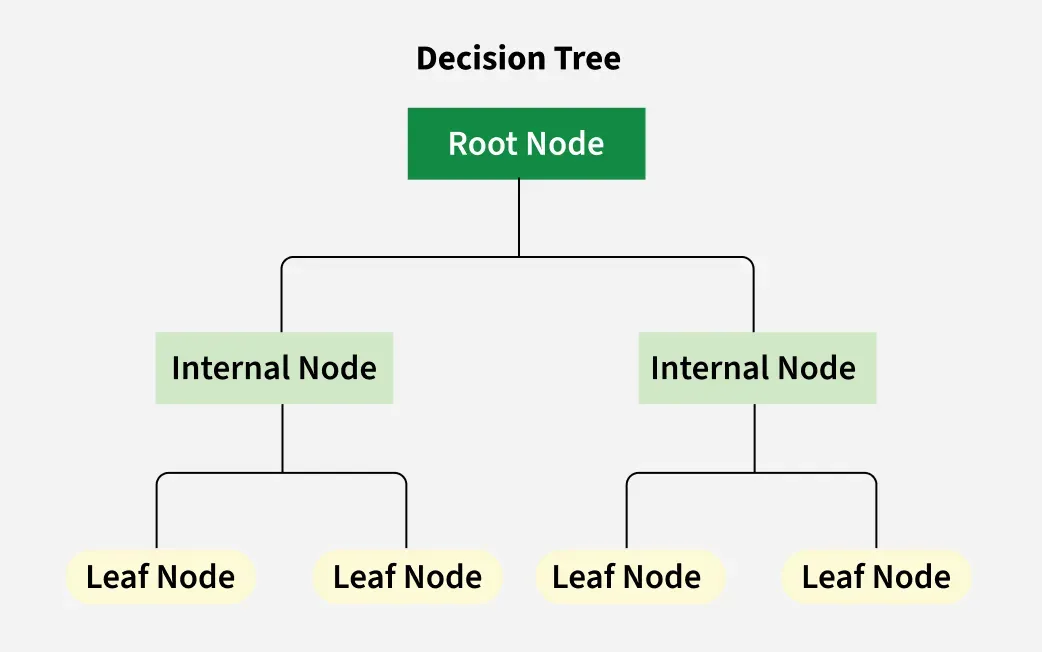

Mathematically, the outcomes can be expressed as:
$$
\hat{y} = \hat{f}(x) = \sum_{m=1}^{M} cm I \{X \in R_m \}

Where:
* $M$: Number of features;
* $cm$: Mean of all the instances in a leaf node;
* $I$: identity function that returns 1 if X in substet $R_m$ and 0 otherwise;
* $R_m$: : The region (subset) corresponding to a leaf node.

**Training and evaluating the model**

In Scikit-Learn, decision trees can be used for both classification and regression tasks. In this case, we will use a decision tree as a regressor.

In [4]:
model_tree = DecisionTreeRegressor()
tree = model_tree.fit(X_train, y_train)

Using the Root Mean Squared Error (RMSE) as scoring for cross-validation, it is possible to evaluate the model performance.

In [5]:
rmse_tree = cross_val_score(tree, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
print(f"The avarage RMSE of the tree model was {-np.mean(rmse_tree)}")

The avarage RMSE of the tree model was 11.933763242136262


* It is better than the linear models performances!

```python
# How to make an image/pdf of a decision tree
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=X_train.columns,
                           filled=True, rounded=True, 
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("decision_tree_visualization")  
graph.view()
```

Another advantage of decisions trees are the visualization. Scikit-Learn (integrated to Graphiviz modules) has a method to produce images of these models. The pdf gerated ("decision_tree_visualization.pdf") is in the GitHub of the project.

**Feature Importance**

In decision trees, interpretation is based on how much a feature reduces uncertainty. This is measured using the Gini coefficient for classifiers and variance reduction for regressors. Scikit-Learn provides a built-in method to assess feature importance based on these criteria.

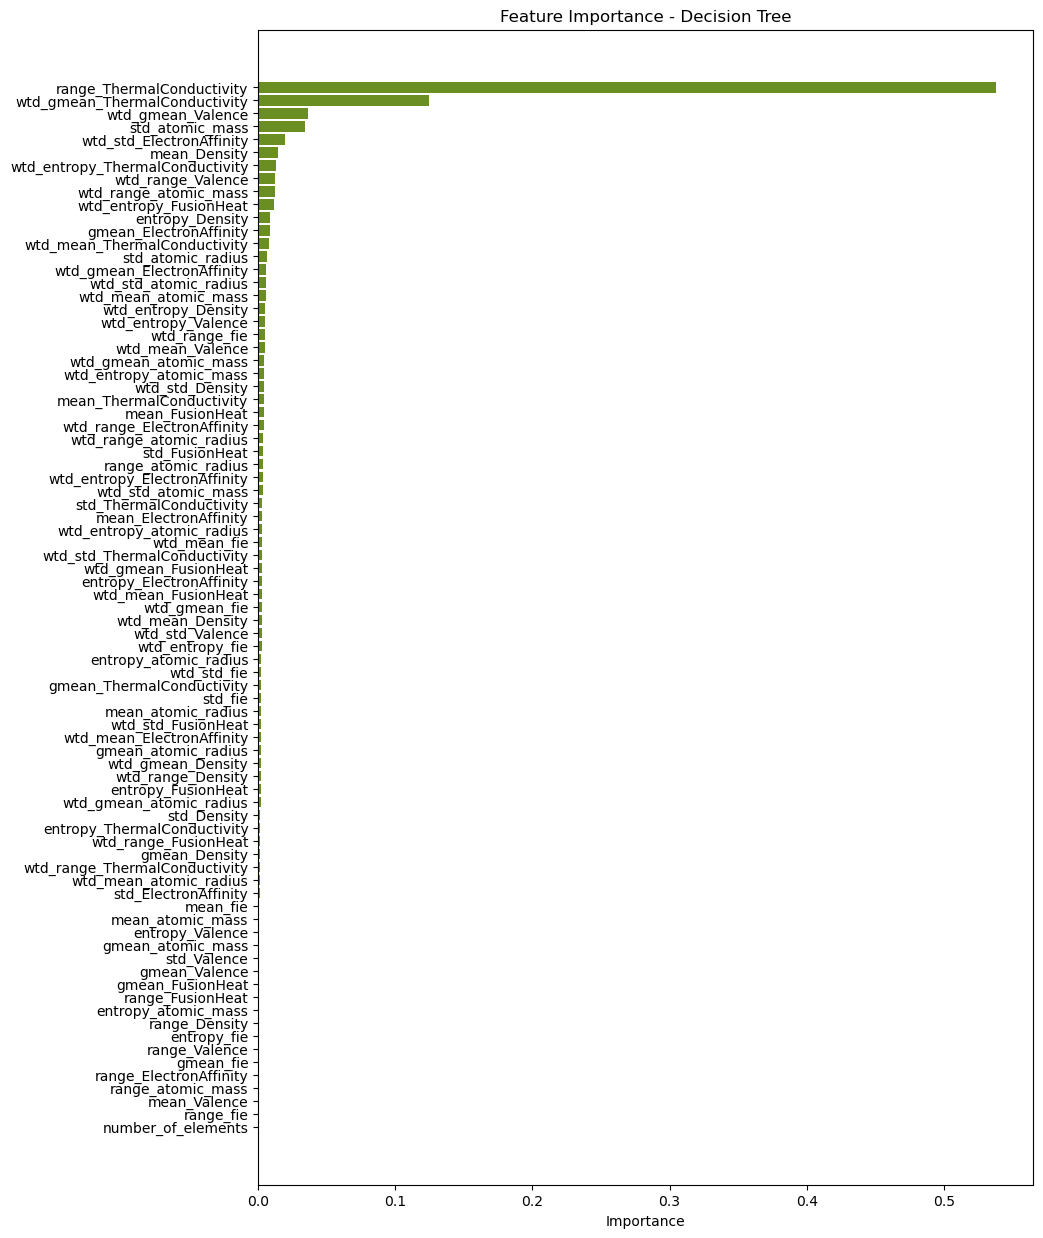

In [6]:
tree_importance = tree.feature_importances_

feature_names = X_train.columns

df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': tree_importance
})

df_importance = df_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 15))
plt.barh(df_importance['Feature'], df_importance['Importance'], color="olivedrab")
plt.xlabel('Importance')
plt.title('Feature Importance - Decision Tree')
plt.gca().invert_yaxis() 
plt.show()

* Features related to Thermal Conductivity represented more than 60% of the feature importance! Other properties apresented similar values.

***

<!DOCTYPE html>
<html>
<body>
    <h3>
        <strong>👪Ensemble methods: Random Forest</strong>
    </h3>
</body>
</html>

Decision trees, besides being one of the most used algorithms for machine learning applications, can be susceptible to overfitting. . To mitigate this issue, an ensemble strategy can be applied. By combining multiple decision trees—each trained on random subsets of the data—it is possible to reduce model variance, enhancing both robustness and predictive accuracy.

In [7]:
model_forest = RandomForestRegressor()
forest = model_forest.fit(X_train, y_train)

In [8]:
rmse_forest = cross_val_score(forest, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
print(f"The avarage RMSE of the tree model was {-np.mean(rmse_forest)}")

The avarage RMSE of the tree model was 9.388987273600243


We lost the visual intepretation, but it is still possible to analyse the feature importance.

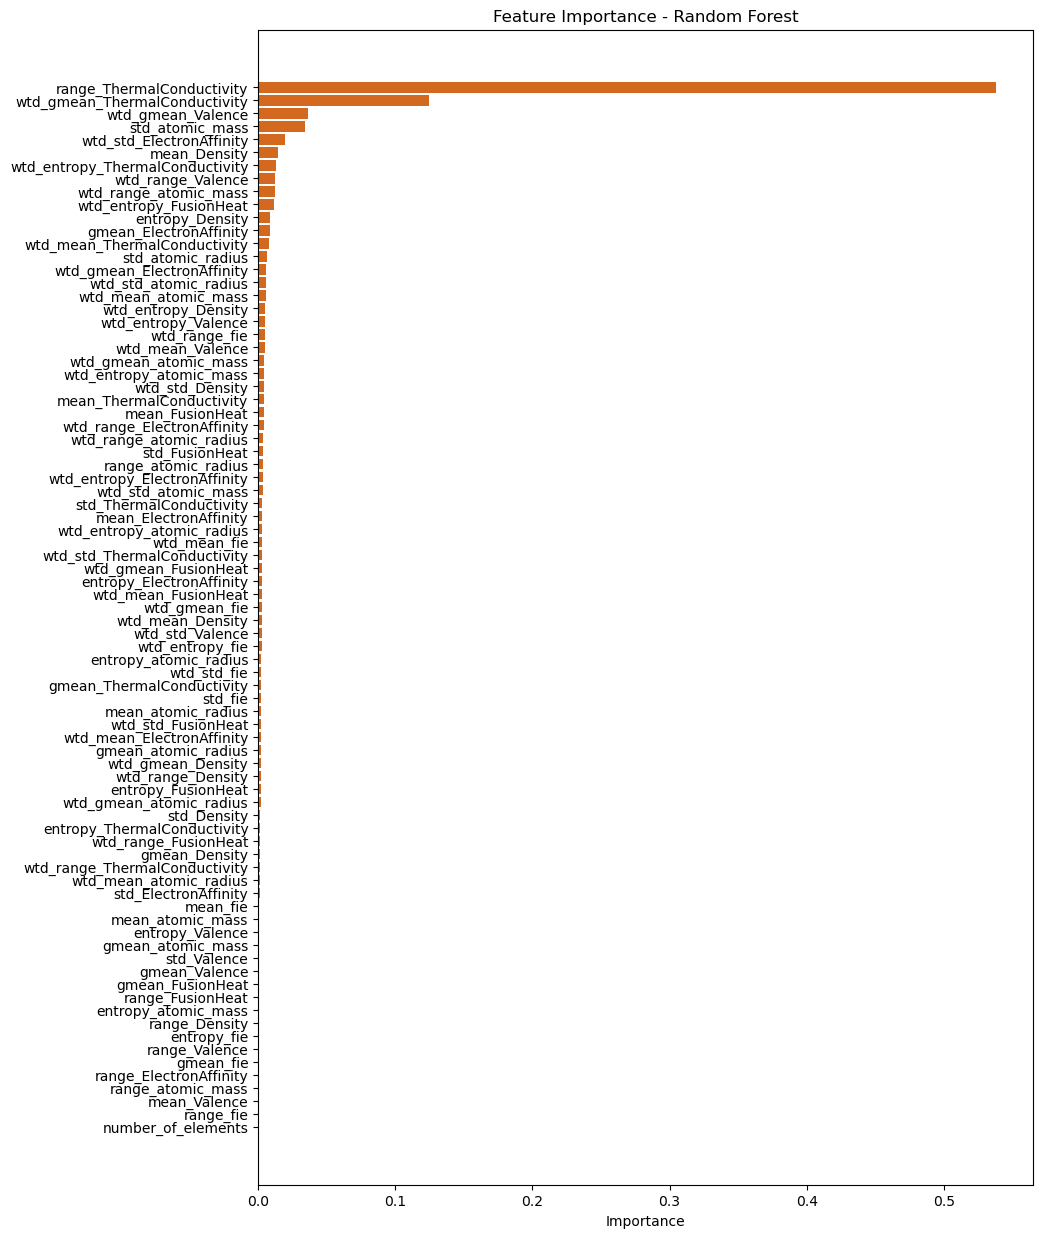

In [9]:
forest_importance = forest.feature_importances_

feature_names = X_train.columns

df_importance_ensemble = pd.DataFrame({
    'Feature': feature_names,
    'Importance': forest_importance
})

df_importance_ensemble = df_importance_ensemble.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 15))
plt.barh(df_importance['Feature'], df_importance['Importance'], color="chocolate")
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis() 
plt.show()

* As happened to Decision Tree, features related to Thermal Conductivity dominated the importance of the model.

***

<!DOCTYPE html>
<html>
<body>
    <h3>
        <strong>SHapley Additive exPlanations (SHAP) </strong>
    </h3>
</body>
</html>

In random forests, the visual interpretaion is lost, but we can still use another techniques to guarantee the model interpretability. One of the most widely used tools in this area is SHapley Additive exPlanations (SHAP), a module that explains the contribution of each feature to an individual prediction (shap values, which are based on the "game theory", by Lloyd Shapley). By considering all instances, it's possible to determine the overall importance of the model. 

To obtain SHAP values, the first step is to calculate the predictions of a baseline model (i.e., a model that doesn't use any features). Next, for each feature, SHAP computes the change in prediction when that feature is added to a subset of other features. Finally, the contribution of each feature is averaged across all possible combinations. This results in the SHAP value for that feature, which indicates how much it contributed, either positively or negatively, to the model’s prediction. [3]

SHAP methods can be categorized into general explainers (model-agnostic) or type-specific explainers (model-specific). For tree-based models, there is a dedicated explainer, so let's make use of it!

In [10]:
explainer = shap.TreeExplainer(forest)

shap_values = explainer.shap_values(X_test) # pure shap values

***

Just saving the explainer :)

In [11]:
# Saving the explainer
import pickle
with open("forest_shap_explainer.pkl", "wb") as shap_explainer:
    pickle.dump(explainer, shap_explainer)
    shap_explainer.close()

In [12]:
with open("forest_shap_explainer.pkl", "rb") as shap_explainer:
     explainer = pickle.load(shap_explainer)

***

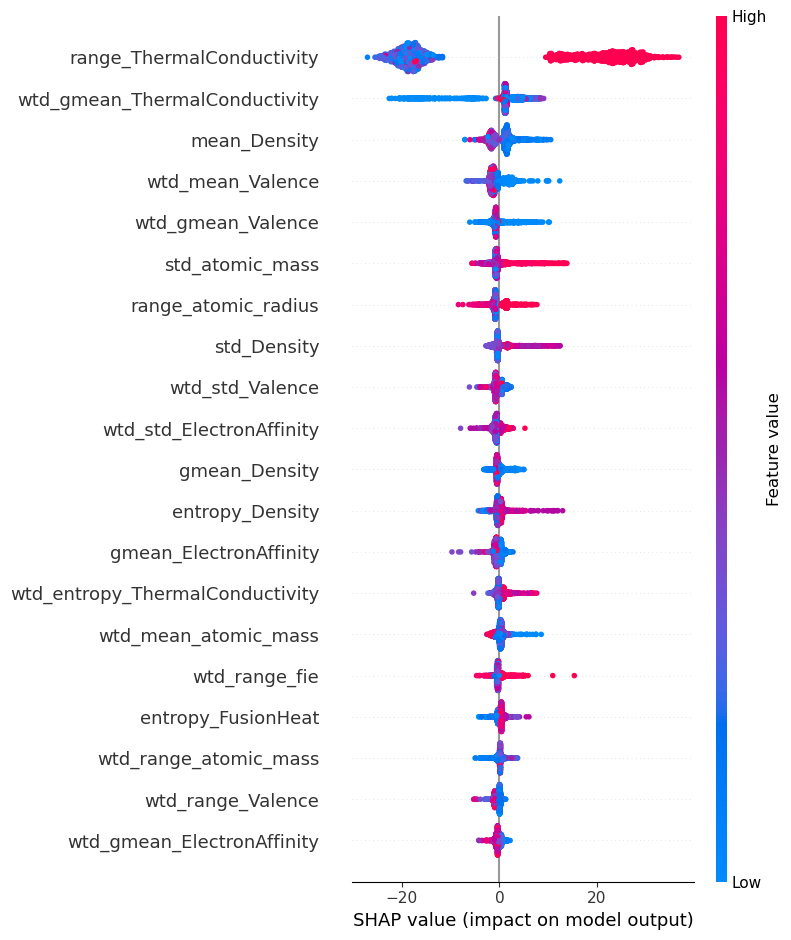

In [13]:
shap.summary_plot(shap_values, X_test, plot_type="dot")

* As demonstrated by the feature importance graphic, features related to thermal conductivity had a significant influence on the model’s predictions, while the other features had minimal impact.

SHAP can be used to analyse local importance, by calculating the contribution of each feature to the final predict. So, let´s test with the highest temperature value in test set.

In [14]:
shap_expl = shap.Explanation(
    values=shap_values, 
    base_values=np.full((X_test.shape[0],), explainer.expected_value), 
    data=X_test
) # creating an Explanation object

In [15]:
max_value = max(y_test)
max_value_idx = np.where(y_test == max_value)[0]

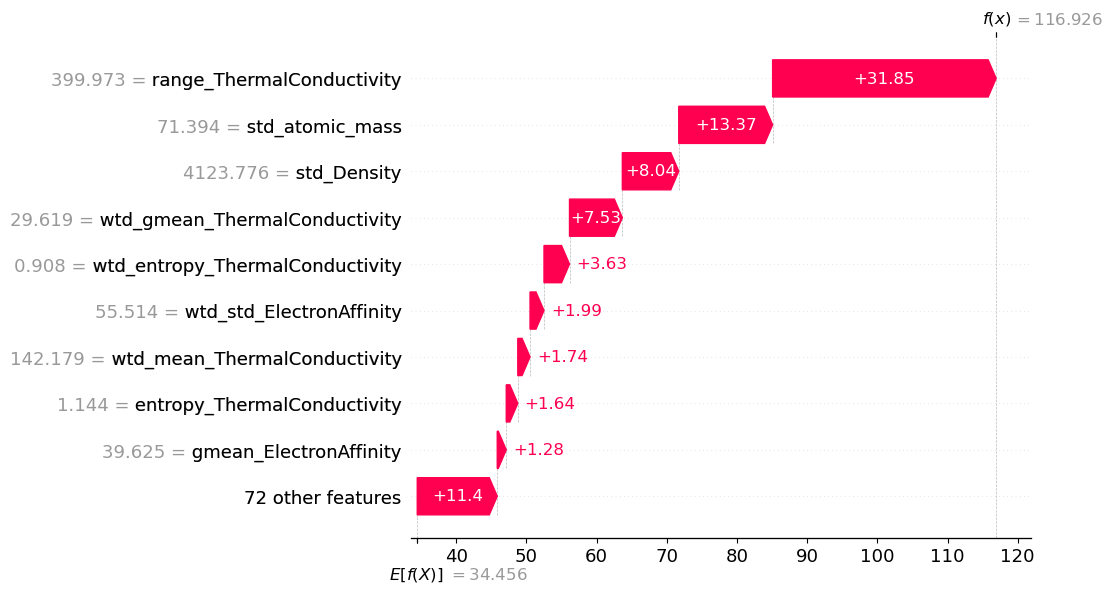

In [20]:
shap.plots.waterfall(shap_expl[max_value_idx][0])  

We can compare this result with a plot of a "standard" value.

In [21]:
mode = stats.mode(y_test)
mode_value_idx = np.where(y_test == mode[0])[0]

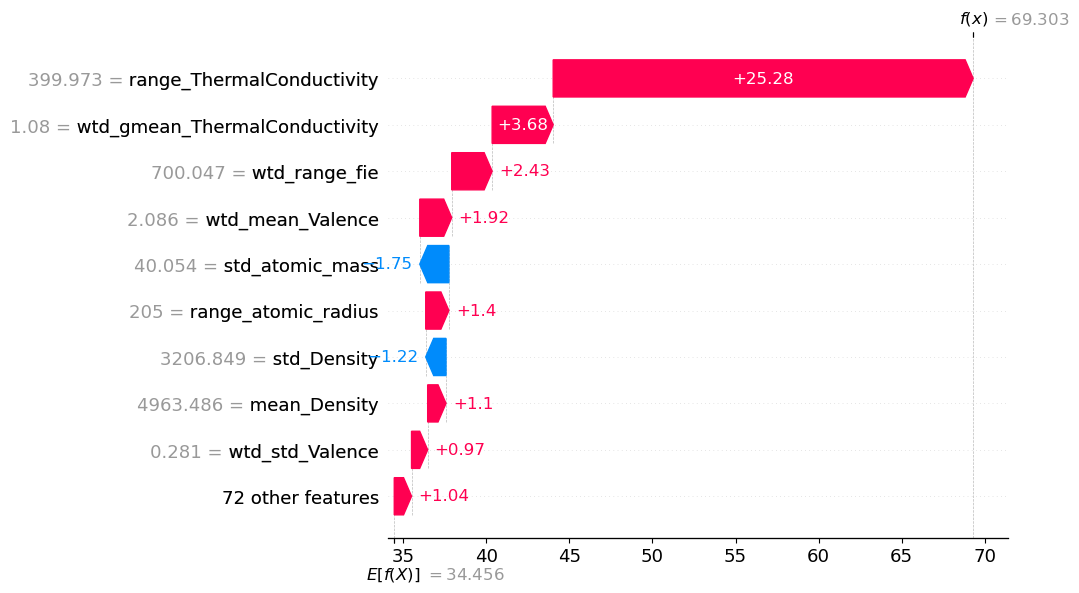

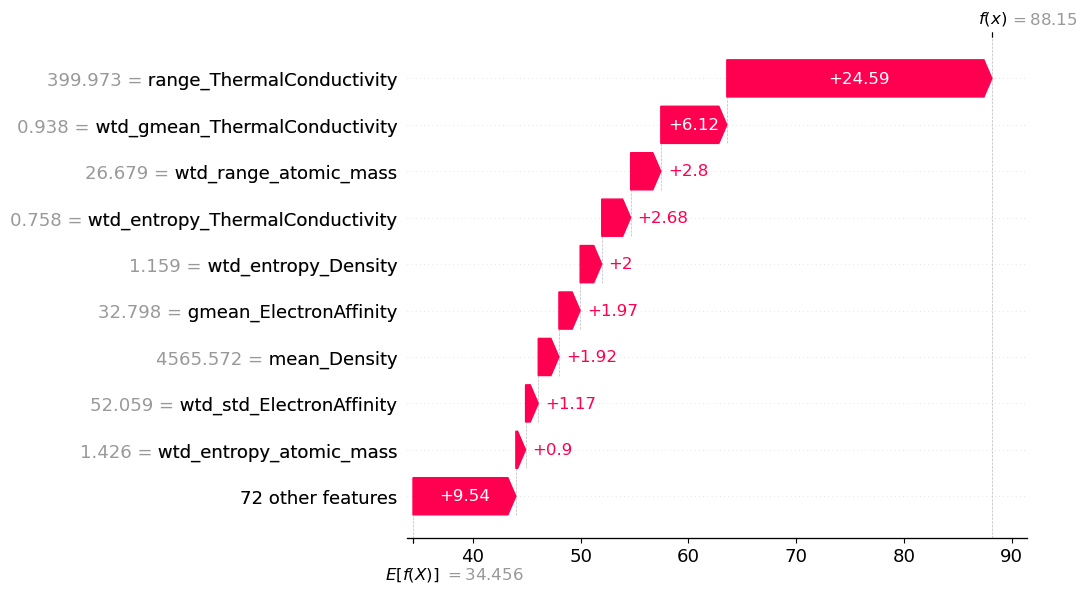

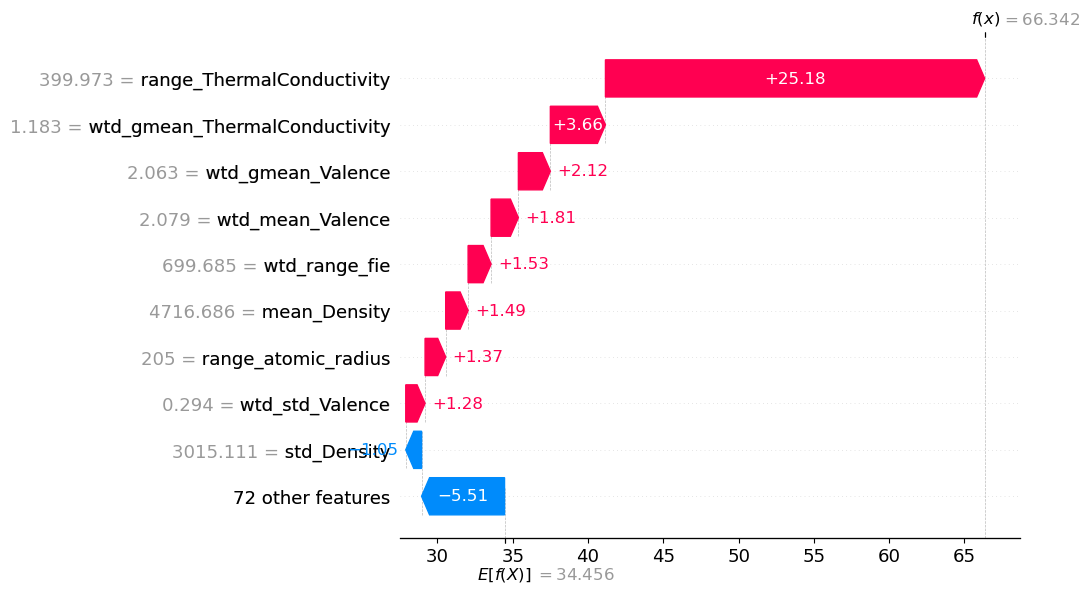

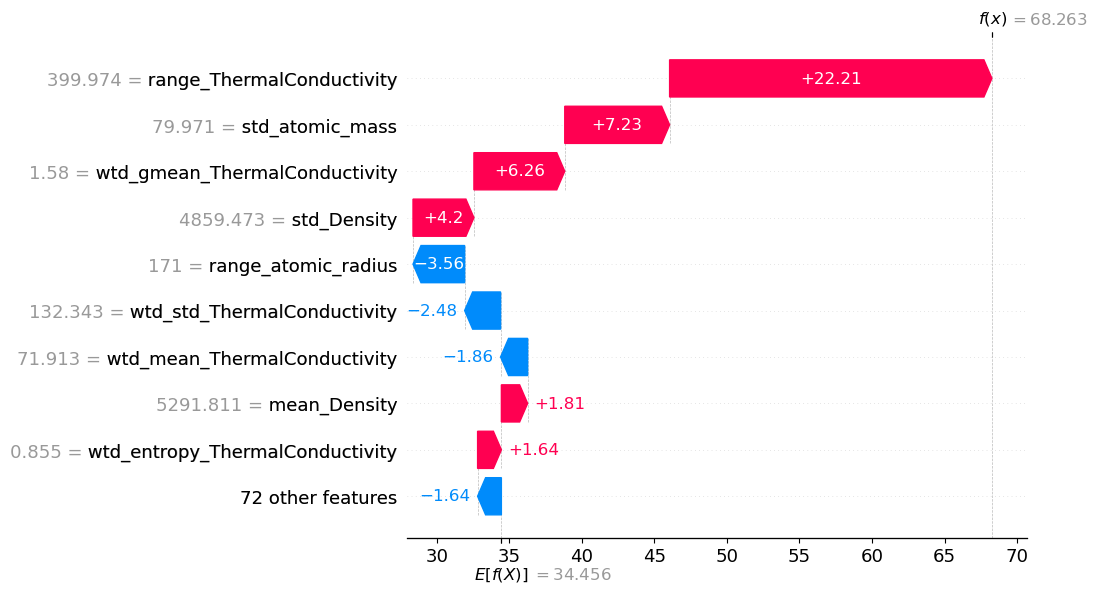

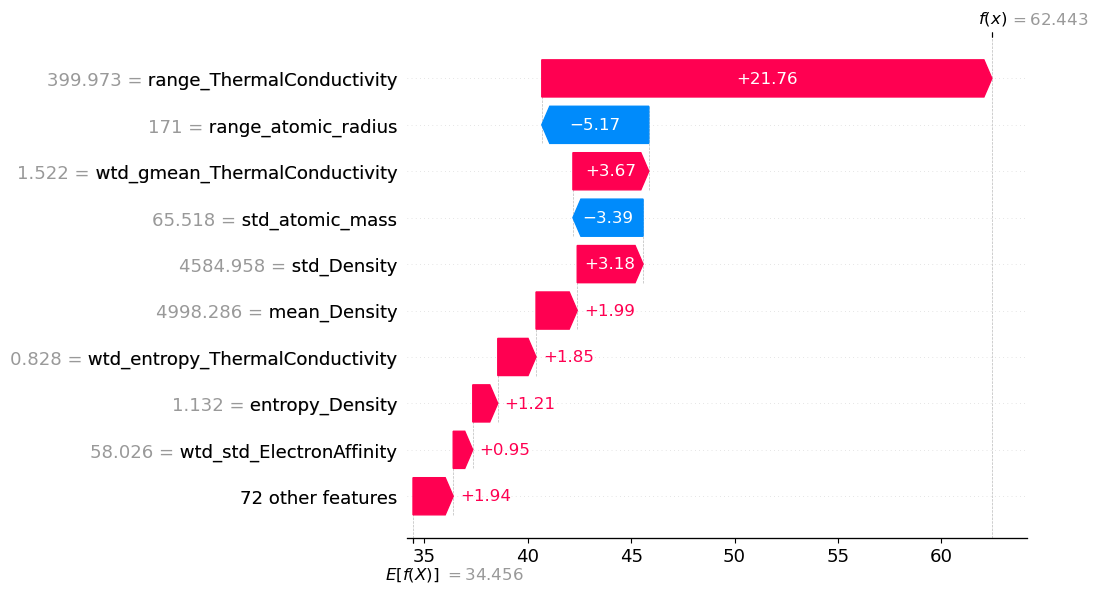

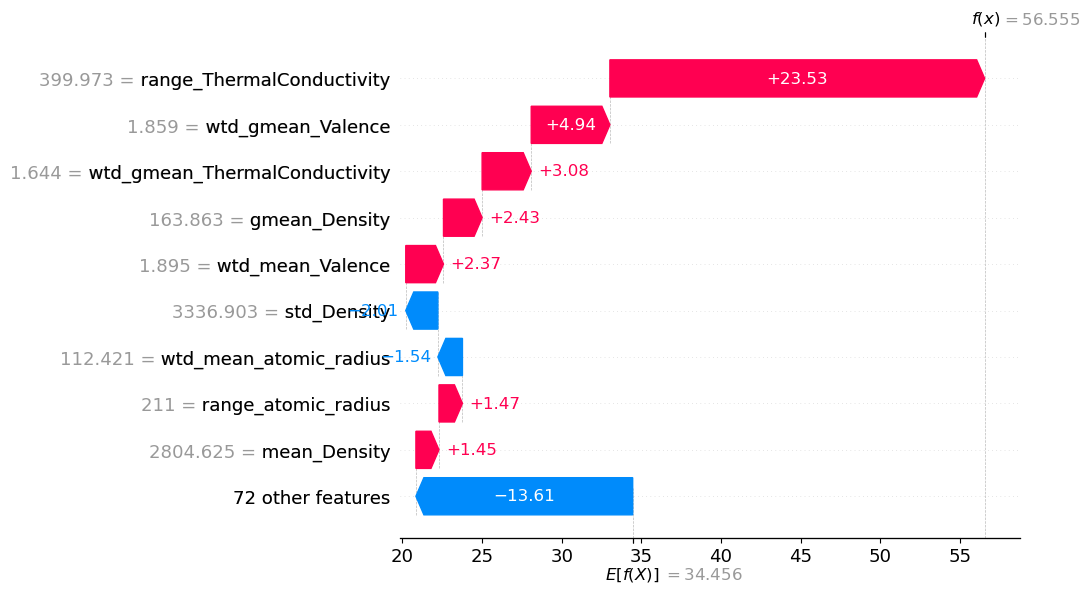

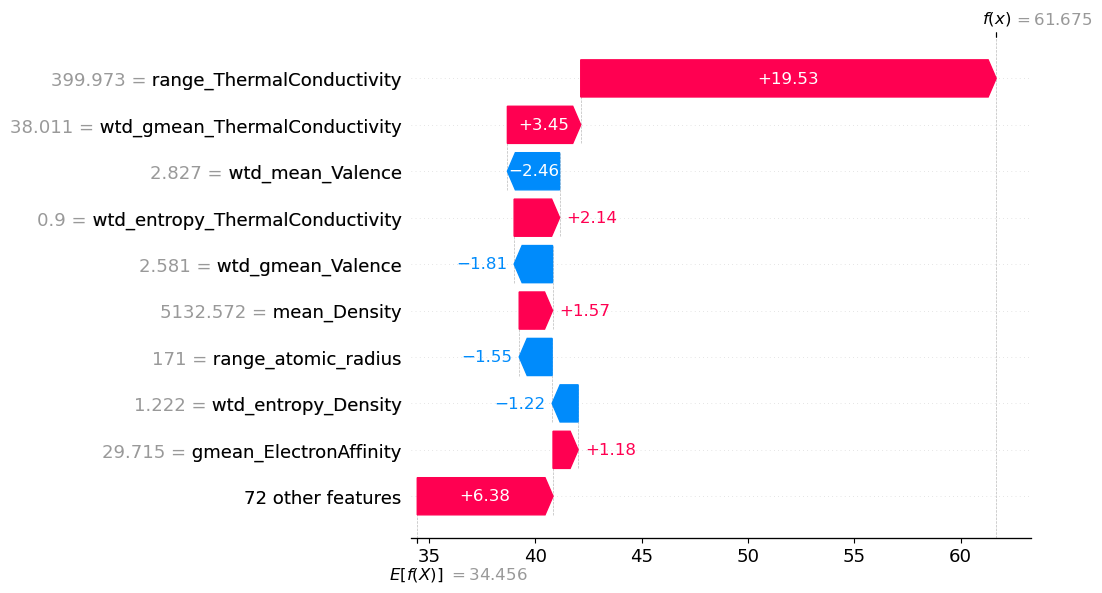

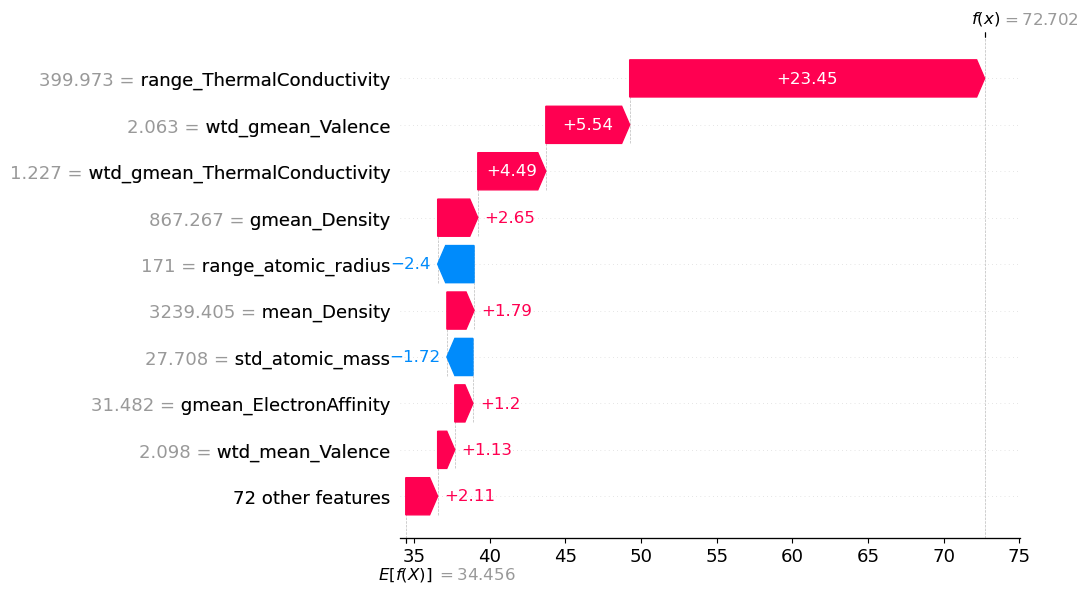

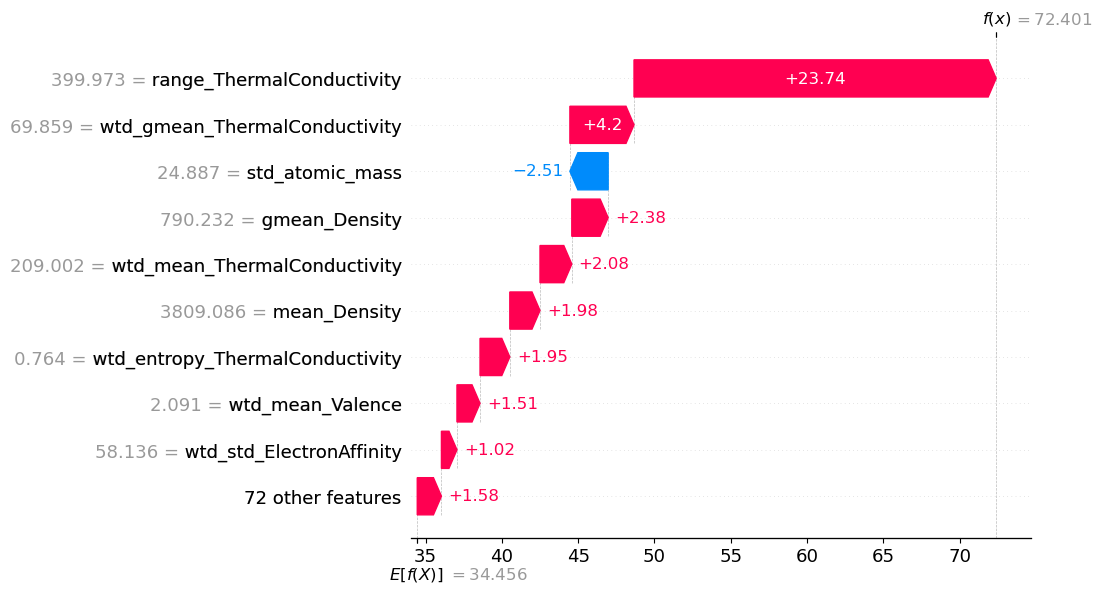

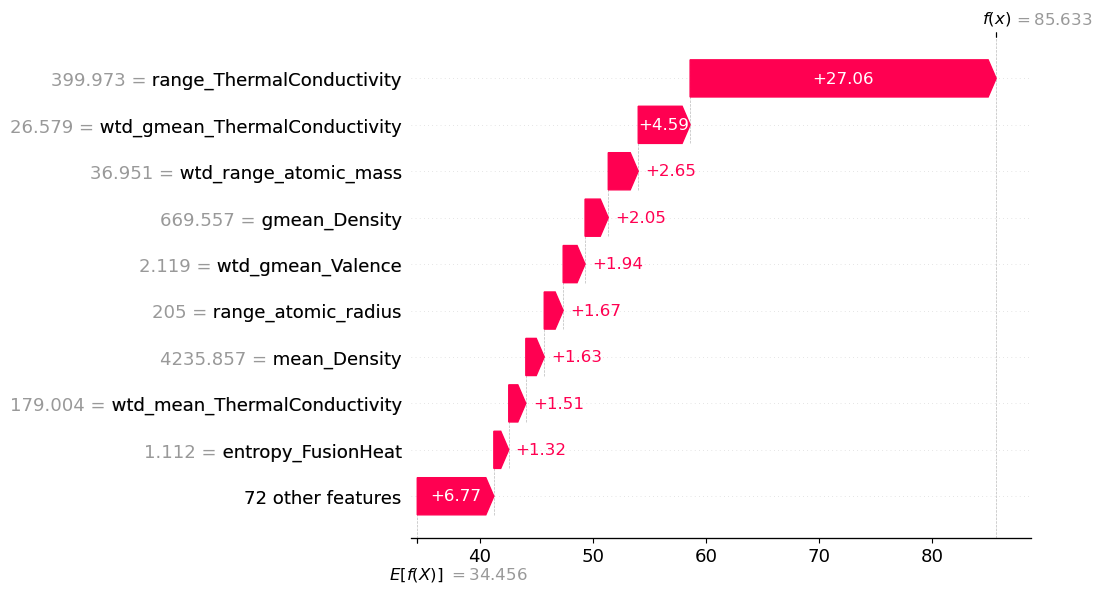

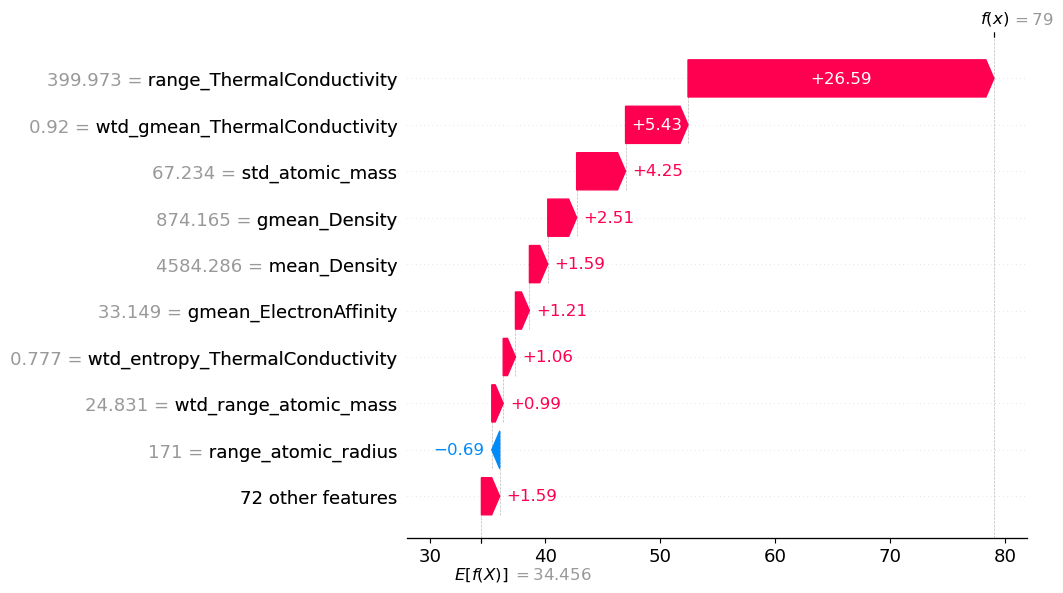

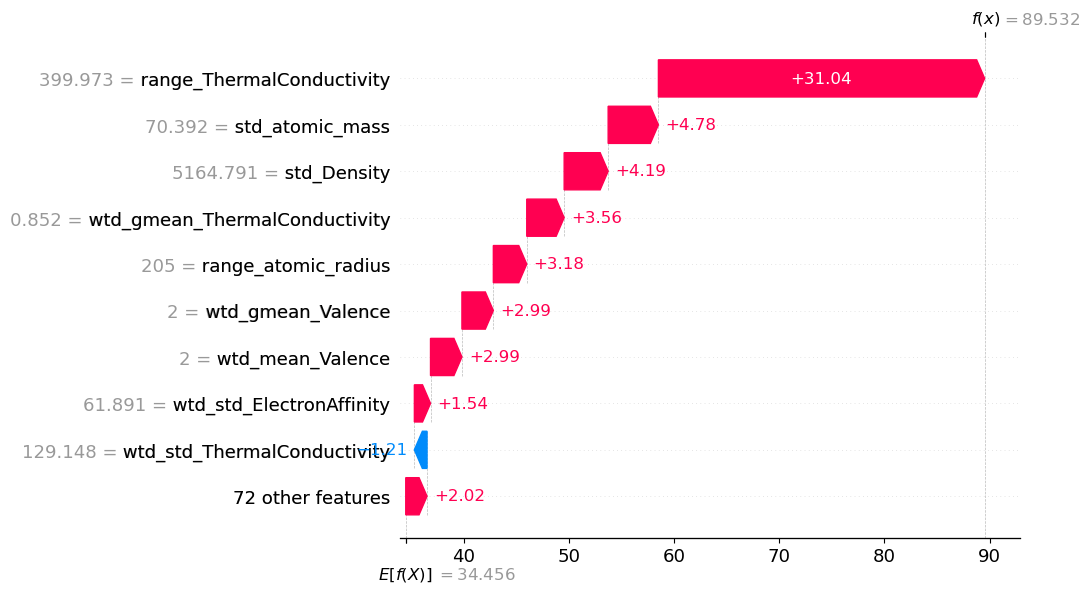

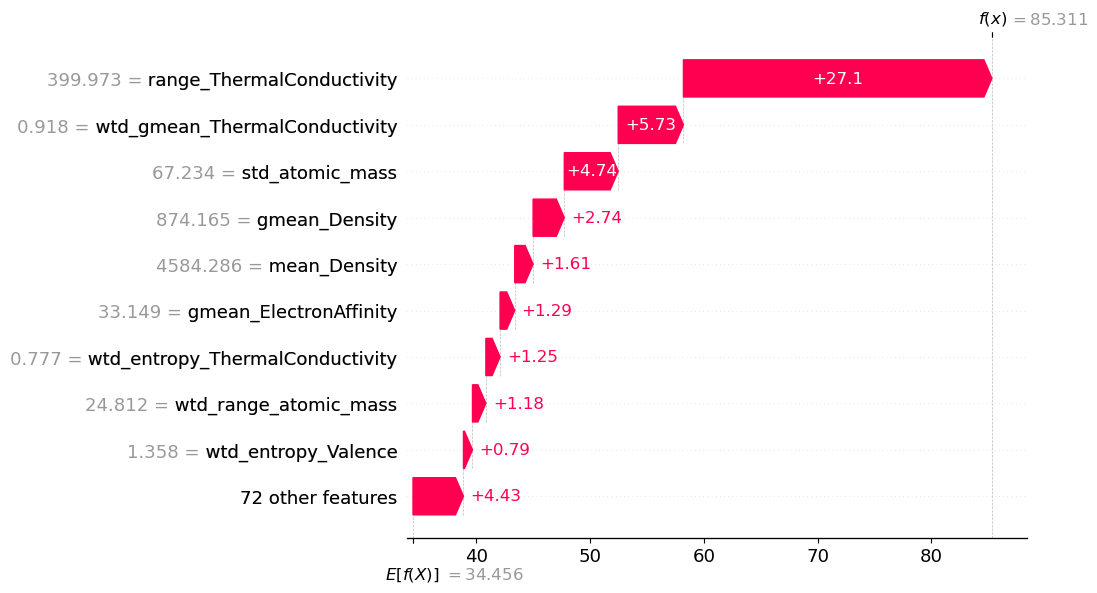

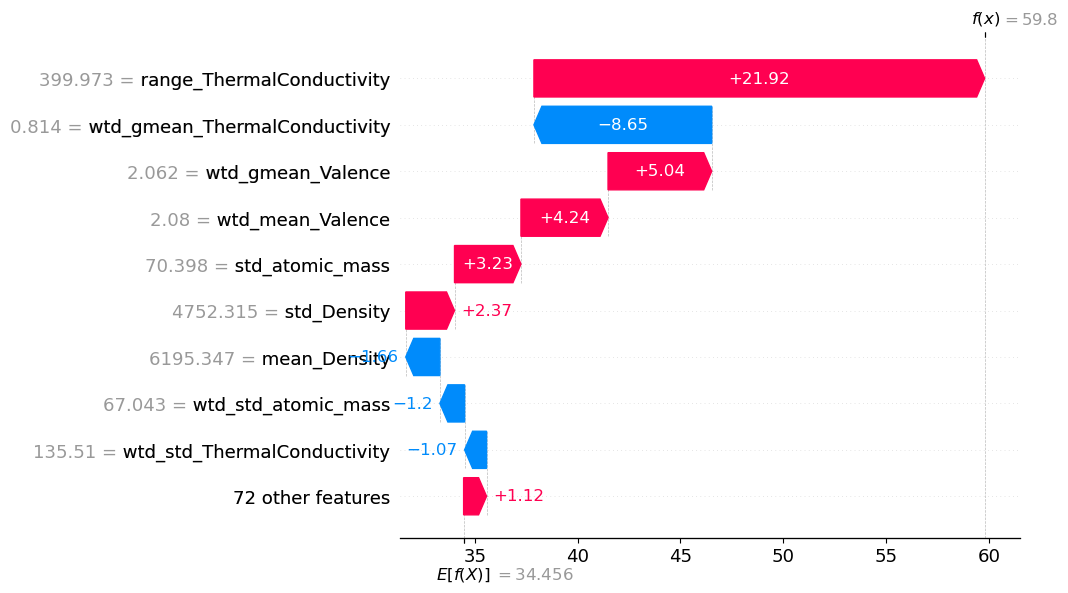

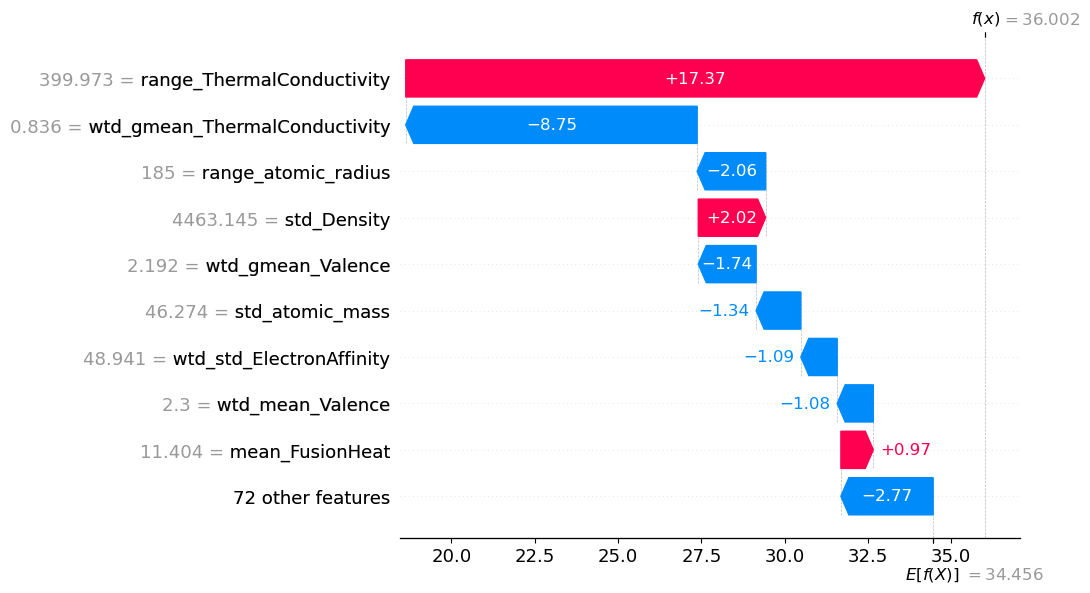

In [22]:
count = 0  

for i in np.where(y_test == mode[0])[0]:  
    shap.plots.waterfall(shap_expl[i])  
    count += 1  

* Visually, no clear pattern emerges from the importance of the instances. However, one consistent observation across all plots is that Thermal Conductivity is the most important feature.

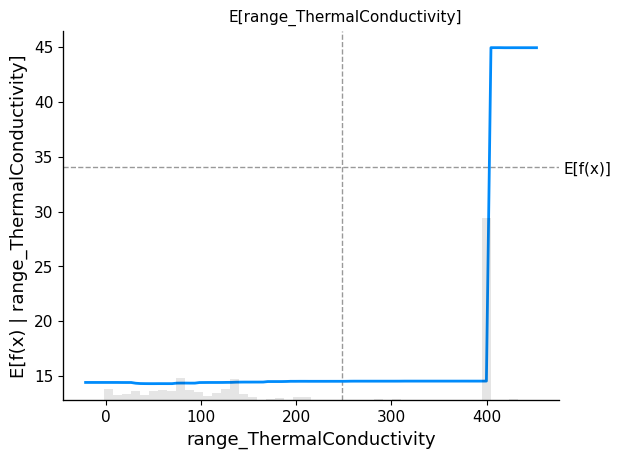

In [23]:
shap.partial_dependence_plot(
    "range_ThermalConductivity",
    forest.predict,
    X_test,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

* High expected values for importance (especially in the high values for range Thermal Conductivity, which are the most frequent values).

One way to analyse shap results is calculate the interaction between shap values. This process is highly costly, so the tree explainer will be used, instead of the random forest one. [4]

In [24]:
explainer_tree = shap.TreeExplainer(tree)

shap_interaction_values = explainer_tree.shap_interaction_values(X_test)

In [25]:
interaction = np.abs(shap_interaction_values).sum(0)

for i in range(interaction.shape[0]):
    interaction[i,i] = 0

idx = np.argsort(-interaction.sum(0))
interaction = interaction[idx,:][:,idx]
columns = X.columns.tolist()
columns = [columns[i] for i in idx]

for i in range(len(interaction)):
    interaction[i][i] = np.nan

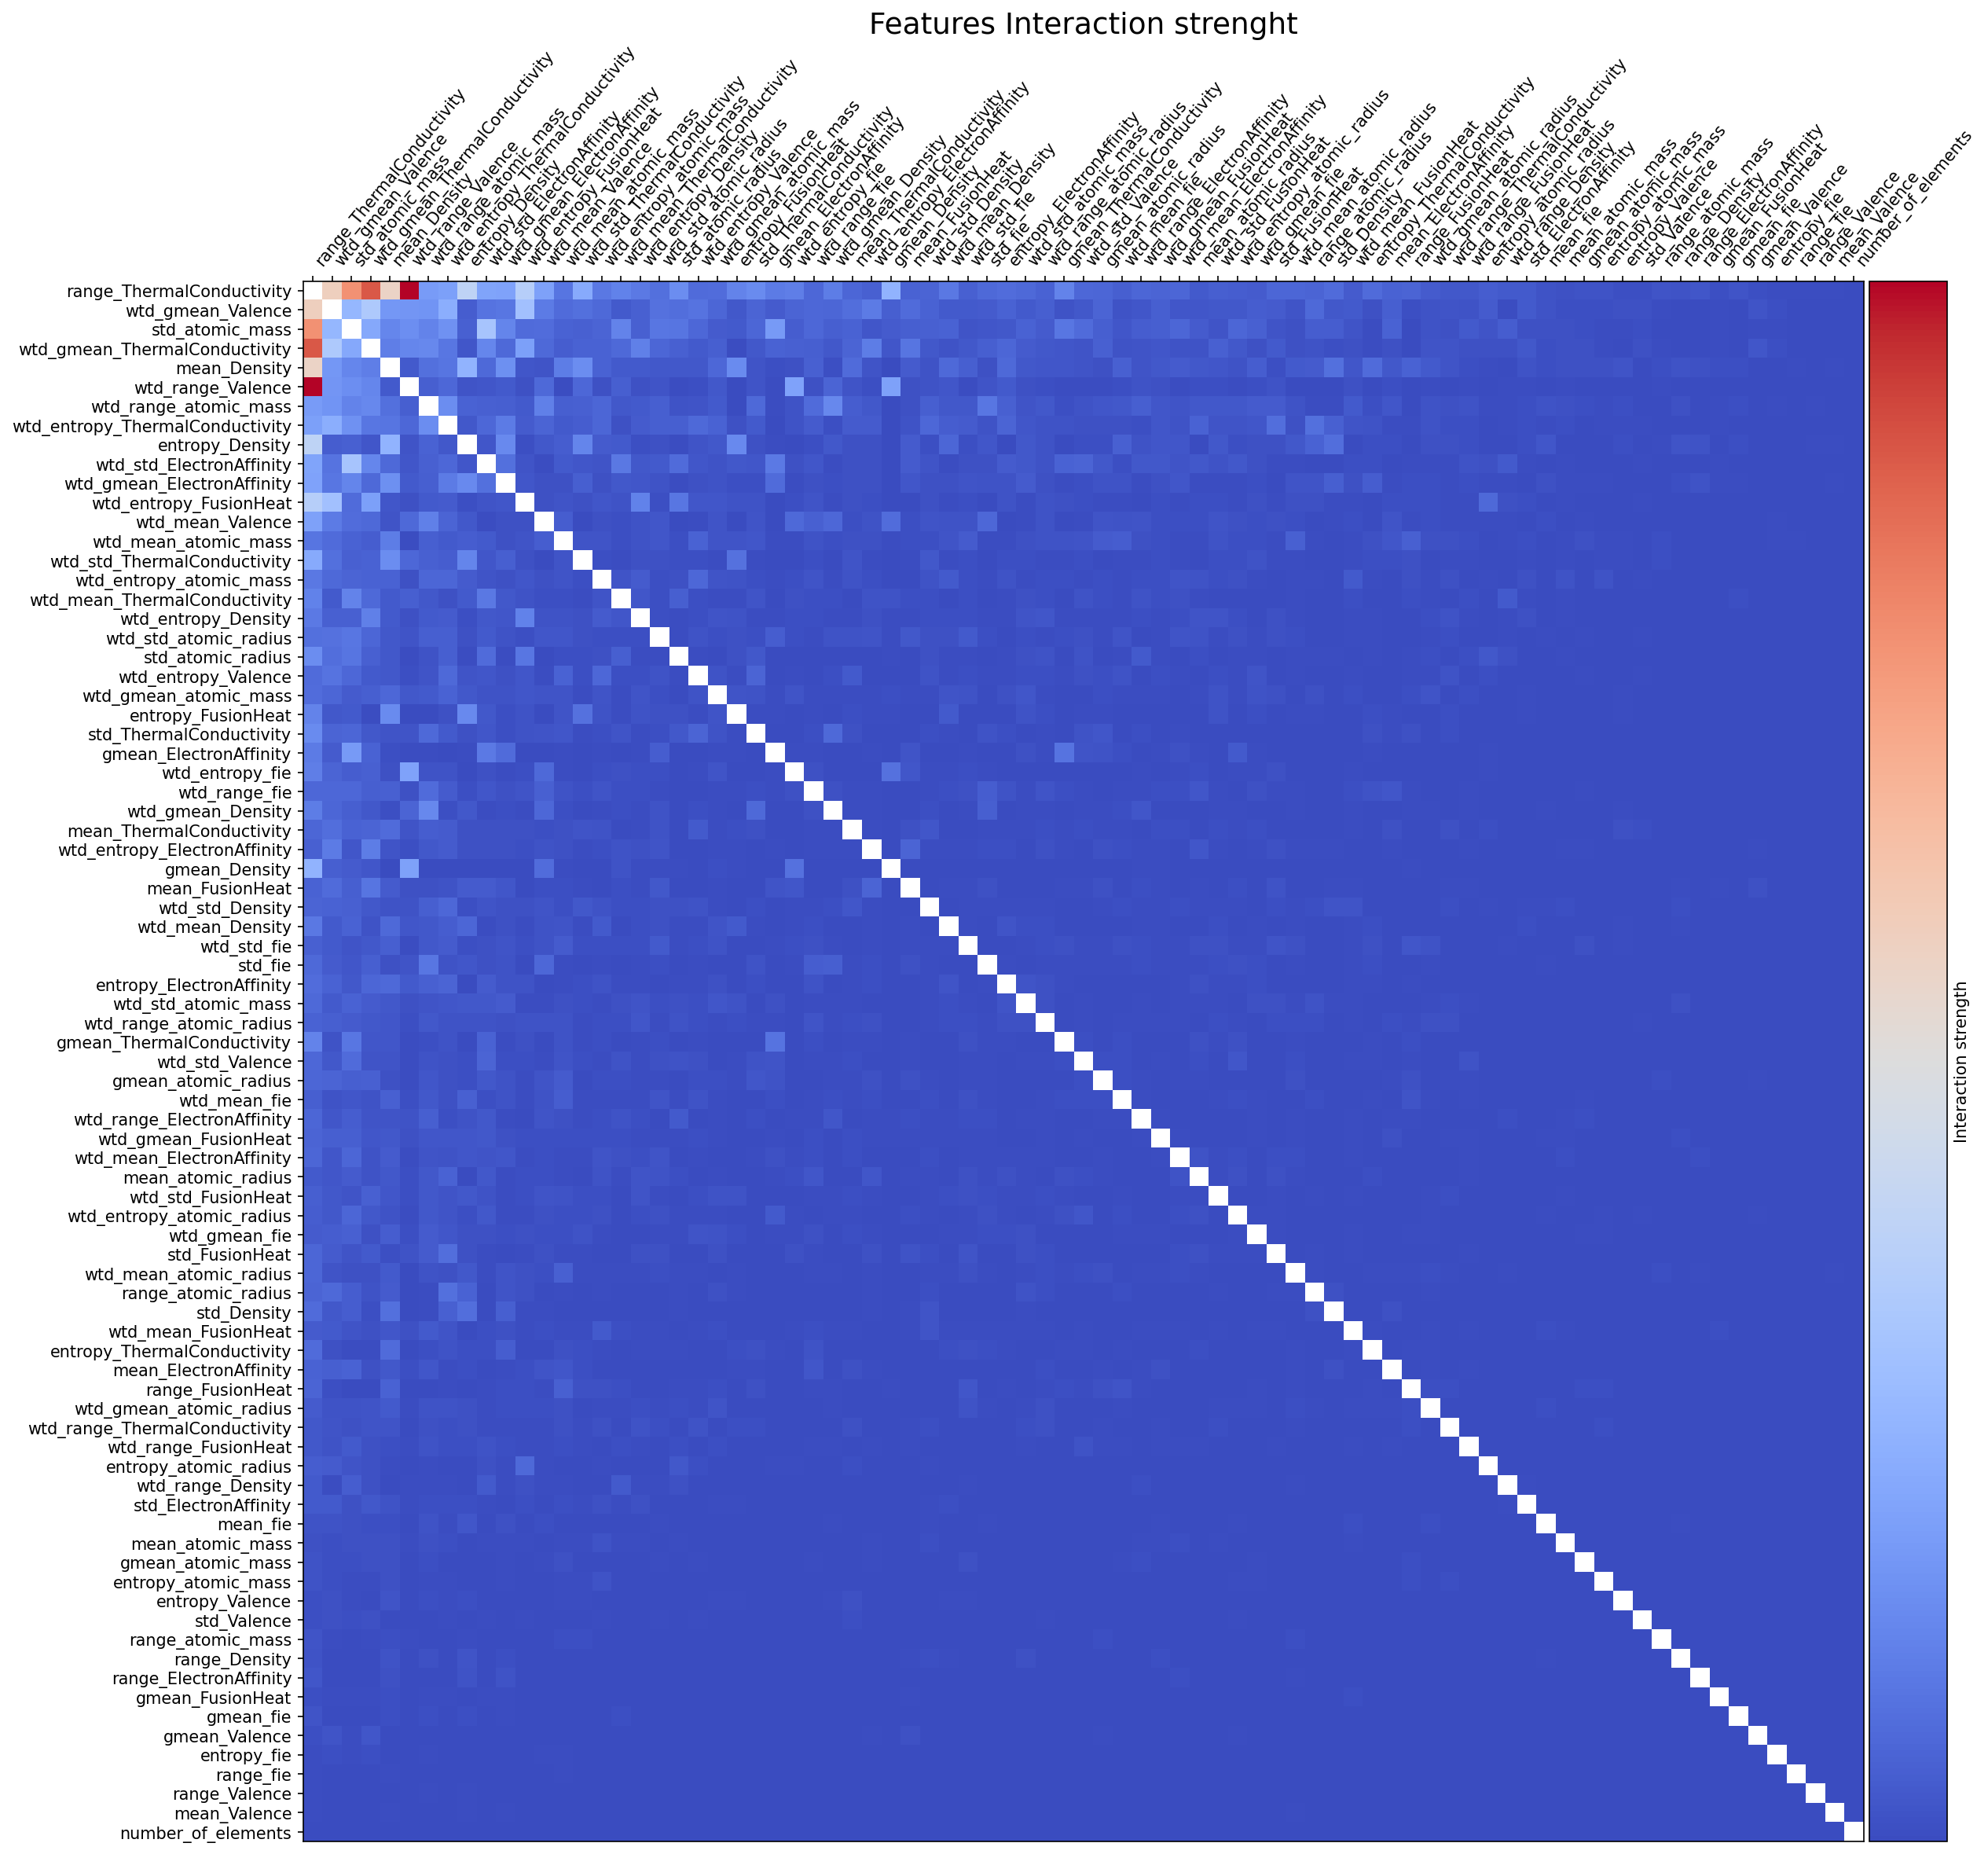

In [41]:
fig, axe = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(18, 18),
    dpi=150,
)

im = axe.imshow(interaction, cmap=plt.get_cmap('coolwarm'))

divider = make_axes_locatable(axe)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label("Interaction strength")
cb.set_ticks([])
cb.set_ticklabels([])

axe.set_yticks(range(interaction.shape[0]), columns)
axe.set_xticks(
    range(interaction.shape[0]),
    columns,
    rotation=50.4,
    horizontalalignment="left",
)
axe.set_title("Features Interaction strenght", fontsize=18)
axe.xaxis.tick_top()

* The majority of the features don´t apresented any interaction with the other features. However, a few atributes, related to Thermal Conductivity, Valence, density and atomic mass, apresented some interaction. It´s intersting to think that these properties were considered as the most important ones in SHAP analysis. The mainly one, ", was the one that most apresented relation with th

***

<!DOCTYPE html>
<html>
<body>
    <h3>
        <strong> 🗃️ References </strong>
    </h3>
</body>
</html>

[1] Molnar, Christoph. Interpretable Machine Learning. christophm.github.io, https://christophm.github.io/interpretable-ml-book/.

[2] “Decision Tree”. GeeksforGeeks, 16 de outubro de 2017, https://www.geeksforgeeks.org/decision-tree/.

[3] Yadav, Amit. “SHAP Values for Random Forest”. Biased-Algorithms, 17 de janeiro de 2025, https://medium.com/biased-algorithms/shap-values-for-random-forest-1150577563c9.

[4] NHANES I Survival Model — SHAP latest documentation. https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/NHANES%20I%20Survival%20Model.html. Acesso em 6 de março de 2025.